
# 주제 : Seq2Seq로 네이버 영화 긍부정 평가하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제는 Naver sentiment movie corpus 데이터를 사용합니다.
    - Naver sentiment movie corpus Dataset은 20만개의 영화 리뷰를 기록해둔 데이터 셋입니다.
    - 모든 데이터는 작성자 id, 리뷰, 긍부정 여부로 되어있습니다.
    - 긍부정 여부는 0,1의 값을 가집니다.
    - 리뷰의 길이는 140자를 넘지 않습니다.
    - 긍부정 비율은 약 50% 내외입니다.
    - 학습 데이터와 정답 데이터는, 각각의 아래와 같습니다.
    
    1. ratings_train
      0	9976970	아 더빙.. 진짜 짜증나네요 목소리	0
      1	3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
      2	10265843	너무재밓었다그래서보는것을추천한다	0
      3	9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
      4	6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...	1
    
    2. ratings_test
      6270596	굳 ㅋ	1
      9274899	GDNTOPCLASSINTHECLUB	0
      8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
      6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0

    
- 데이터 출처: [nsmc](https://github.com/e9t/nsmc)


## 최종 목표
    - Seq2Seq 기반 모델의 이해
    - word embedding 이해
    - 시계열 데이터 학습 이해
    
  - 출제자 : 손근영 강사


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## Step 1. 도입전 기본 처리

### 문제 1. 네이버 데이터 다운 받기

In [ ]:
# 데이터를 불러오는 코드를 작성해주세요.
# https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

In [3]:
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Feb 18 14:33 .
drwxr-xr-x 1 root root 4096 Mar  4 03:47 ..
drwxr-xr-x 1 root root 4096 Feb 18 14:33 .config
drwxr-xr-x 1 root root 4096 Feb 18 14:33 sample_data


In [4]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt

--2022-03-04 03:49:20--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4893335 (4.7M) [text/plain]
Saving to: ‘ratings_test.txt’

ratings_test.txt    100%[===================>]   4.67M  --.-KB/s    in 0.09s   

2022-03-04 03:49:21 (51.5 MB/s) - ‘ratings_test.txt’ saved [4893335/4893335]

--2022-03-04 03:49:21--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to

In [7]:
!ls -alh

total 19M
drwxr-xr-x 1 root root 4.0K Mar  4 03:49 .
drwxr-xr-x 1 root root 4.0K Mar  4 03:47 ..
drwxr-xr-x 1 root root 4.0K Feb 18 14:33 .config
-rw-r--r-- 1 root root 4.7M Mar  4 03:49 ratings_test.txt
-rw-r--r-- 1 root root  14M Mar  4 03:49 ratings_train.txt
drwxr-xr-x 1 root root 4.0K Feb 18 14:33 sample_data


In [8]:
!cat ratings_train.txt | head -n10

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


In [22]:
!cat ratings_test.txt | head -n10

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0


### 문제 2. 네이버 데이터 판다스 데이터프레임에 로드하기

In [9]:
# 데이터를 불러오는 코드를 작성해주세요.
train_df = pd.read_csv("ratings_train.txt", sep="\t")
test_df = pd.read_csv("ratings_test.txt", sep="\t")

### 문제 3. train_df/test_df의 shape/dtype을 출력해보세요.

In [10]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [14]:
# train_text/topic의 dtype을 출력해보세요.
print(train_df.dtypes)
print("-------------")
print(test_df.dtypes)

id           int64
document    object
label        int64
dtype: object
-------------
id           int64
document    object
label        int64
dtype: object


In [26]:
np.concatenate([train_df.document, test_df.document]) 

array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
       '너무재밓었다그래서보는것을추천한다', ..., '그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다',
       '절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네', '마무리는 또 왜이래'],
      dtype=object)

In [27]:
np.concatenate([train_df.document.values, test_df.document.values]) 

array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
       '너무재밓었다그래서보는것을추천한다', ..., '그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다',
       '절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네', '마무리는 또 왜이래'],
      dtype=object)

### 문제 4. train_df에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.

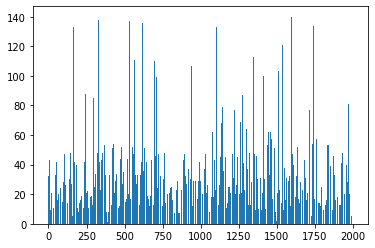

In [17]:
# train_text에서 각 원소의 길이를 y축으로 bar plot를 그려보세요.
plt.bar( range(2000), [len(str(text)) for text in train_df.sample(2000).document] )
plt.show()

## Step 2. 전처리

### 문제 5. 형태소 분석기 설치

In [19]:
# 형태소 분석기 설치
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.6 MB/s 
     |████████████████████████████████| 448 kB 45.0 MB/s 


In [20]:
from konlpy.tag import Okt
okt = Okt()
okt.pos("긴 하루 지나고 언덕 저편에 빨간 석양이 물들어가면")

[('긴', 'Verb'),
 ('하루', 'Noun'),
 ('지나고', 'Verb'),
 ('언덕', 'Noun'),
 ('저편', 'Noun'),
 ('에', 'Josa'),
 ('빨간', 'Adjective'),
 ('석양', 'Noun'),
 ('이', 'Josa'),
 ('물들어가면', 'Verb')]

### 문제 6. sentencepiece 설치 및 data 학습

In [21]:
# sentencepiece 설치 및 data 학습
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.1 MB/s 


In [29]:
import sentencepiece as spm
full_doc = np.concatenate([train_df.document.values, test_df.document.values])
with open('full_doc.txt', 'w', encoding='utf8') as f:
    for line in full_doc:
        if len(str(line).strip()) == 0:
            continue
        try:
            f.write(line + "\n")
        except:
            continue

In [30]:
spm.SentencePieceTrainer.Train('--input=full_doc.txt --model_prefix=m --vocab_size=20000')

In [31]:
vocab_list = pd.read_csv('m.vocab', sep='\t')
vocab_list.sample(10)

,<unk>,0
8115,▁베껴,-11.8706
2734,▁프레데터,-11.2987
5570,▁유치하게,-11.5870
10721,▁밥그릇,-12.2879
4160,▁들었습니다,-11.4426
2005,살에,-11.2219
7650,▁코미디물,-11.8208
7691,▁주진모,-11.8227
11364,쿤,-12.6390
2755,▁하시는,-11.3012


In [32]:
len(vocab_list)

11558

### 문제 7. sentencepiece 모델 로드 및 텍스트 분석


In [34]:
# sentencepiece 모델 로드 및 텍스트 분석
sp = spm.SentencePieceProcessor()
vocab_file = "m.model"
sp.load(vocab_file)

True

In [35]:
sp.encode_as_pieces('이젠 나 같은 사람 만나지 마요. 혹시 찾아가도 두 번 다시 나를 허락해주지 마요.')

['▁이젠',
 '▁나',
 '▁같은',
 '▁사람',
 '▁만나',
 '지',
 '▁마',
 '요',
 '.',
 '▁혹시',
 '▁찾아',
 '가',
 '도',
 '▁두',
 '▁번',
 '▁다시',
 '▁나를',
 '▁허락',
 '해',
 '주지',
 '▁마',
 '요',
 '.']

### 문제 8. 텍스트 id로 인코딩 및 디코딩

In [36]:
# 텍스트 id로 인코딩
sp.encode_as_ids('이젠 나 같은 사람 만나지 마요. 혹시 찾아가도 두 번 다시 나를 허락해주지 마요.')

[1691,
 166,
 206,
 376,
 2426,
 25,
 610,
 61,
 3,
 4503,
 842,
 12,
 11,
 307,
 1133,
 105,
 1764,
 18198,
 71,
 4999,
 610,
 61,
 3]

In [37]:
sp.decode_pieces(['▁이젠','▁나','▁같은','▁사람','▁만나','지','▁마','요','.','▁혹시','▁찾아','가','도','▁두','▁번','▁다시','▁나를','▁허락','해','주지','▁마','요','.'])

'이젠 나 같은 사람 만나지 마요. 혹시 찾아가도 두 번 다시 나를 허락해주지 마요.'

In [38]:
sp.decode_ids([1691,166,206,376,2426,25,610,61,3,4503,842,12,11,307,1133,105,1764,18198,71,4999,610,61,3])

'이젠 나 같은 사람 만나지 마요. 혹시 찾아가도 두 번 다시 나를 허락해주지 마요.'

### 문제 8. sentencepiece로 train/test document 필드 분석 후 저장

In [40]:
# sentencepiece로 train/test document 필드 분석 후 저장
train_df["bow"] = train_df.document.apply(lambda x: sp.encode_as_ids(str(x)))
test_df["bow"] = train_df.document.apply(lambda x: sp.encode_as_ids(str(x)))

In [41]:
train_df

,id,document,label,bow
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[55, 994, 5, 26, 15931, 1230]"
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[1496, 6, 4790, 159, 1679, 34, 406, 50, 15263,..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[18, 490, 19798, 534, 3011, 13494, 14, 2179, 291]"
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[14238, 198, 6996, 4, 5, 3717, 945, 90, 5, 687..."
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[3048, 5653, 1839, 235, 9, 18573, 2090, 330, 1..."
...,...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0,"[2479, 775, 25, 5, 541, 13, 633, 2754, 280, 5]"
149996,8549745,평점이 너무 낮아서...,1,"[115, 18, 2460, 6]"
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,"[103, 148, 61, 15, 3663, 17, 353, 68, 960, 103..."
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,"[2330, 393, 4812, 3, 482, 2429, 33, 3155, 387,..."


### 문제 9. 형태소 분석기로 document 필드 분석

In [ ]:
# 형태소 분석기로 document 필드 분석
# train_df['tag'] = train_df.document.apply(lambda x: okt.pos(str(x)))

### 문제 10. train/test 에 대한 x, y 데이터를 만들어보자 (train_text, train_sentiment, test...)

In [43]:
# train/test 에 대한 x, y 데이터 생성
train_text = train_df.bow.values
test_text = test_df.bow.values

In [44]:
test_text

array([list([55, 994, 5, 26, 15931, 1230]),
       list([1496, 6, 4790, 159, 1679, 34, 406, 50, 15263, 411, 1339, 8024, 885, 443]),
       list([18, 490, 19798, 534, 3011, 13494, 14, 2179, 291]), ...,
       list([95, 5576]), list([802, 1673, 56, 85, 673, 191, 3031]),
       list([17048, 96, 836, 929, 487, 7, 3])], dtype=object)

In [45]:
train_sentiment = train_df.label.values
test_sentiment = test_df.label.values

In [46]:
test_sentiment

array([1, 0, 0, ..., 0, 0, 0])

### 문제 11. train_text, test_text에서 등장한 정수들을 알아보자

In [50]:
# train_text, test_text에서 등장한 정수들을 알아보자
all_words = set(word for text in train_text for word in text) | set(word for text in test_text for word in text)
print(sorted(all_words)[:5])
print(sorted(all_words)[-5:])

[0, 3, 4, 5, 6]
[19995, 19996, 19997, 19998, 19999]


### 문제 12. train_text와 test_text를 BOW 형태로 변경

In [51]:
# train_text와 test_text를 BOW 형태로 변경하세요.
train_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_text, padding="post", value=0)
test_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, padding="post", value=0)

In [52]:
train_bow_text.shape, test_bow_text.shape

((150000, 132), (50000, 117))

### 문제 13. train과 test에 나온 word들의 count를 측정해보자

In [62]:
# train과 test에 나온 word들의 count를 측정해보자
import collections
word_count = collections.Counter()

for text in train_text:
    word_count.update(text)
for text in test_text:
    word_count.update(text)

In [63]:
word_count.most_common(10)

[(3, 93307),
 (4, 48354),
 (5, 40894),
 (6, 33379),
 (7, 30147),
 (9, 24192),
 (10, 24170),
 (8, 23739),
 (11, 20854),
 (12, 19271)]

### 문제 14. word_count를 이용해서 n번 이하로 나온 word를 삭제하여 train과 test를 구성하여보자.

In [67]:
# word_count를 이용해서 n번 미만으로 나온 word를 삭제하여 train과 test를 구성하여보자.
def cut_by_count(texts, n):
    return np.array([[word for word in text if word_count[word] >= n] for text in texts])

In [70]:
train_cut_text = cut_by_count(train_text, 20)
test_cut_text = cut_by_count(test_text, 20)

In [71]:
train_cut_text.shape, test_cut_text.shape

((150000,), (50000,))

### 문제 15. pad 추가된 bow 형태로 변화하여 width 길이를 확인해보세요.

In [72]:
# bow 형태로 변화하여 width 길이를 확인해보세요.
train_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(train_cut_text, padding="post", value=0)
test_cut_bow_text = tf.keras.preprocessing.sequence.pad_sequences(test_cut_text, padding="post", value=0)

In [73]:
train_cut_bow_text.shape, test_cut_bow_text.shape

((150000, 132), (50000, 117))

### 문제 16. train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.

In [74]:
# train_text/test_text에 길이 제한을 줘서 bow를 생성해보세요.
train_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(train_text, value =0, maxlen=100)
test_cut_bow_text2 = tf.keras.preprocessing.sequence.pad_sequences(test_text, value =0, maxlen=100)

In [75]:
train_cut_bow_text2.shape, test_cut_bow_text2.shape

((150000, 100), (50000, 100))

### 문제 17. sentiment을 onehot encoding으로 변경해보세요.

In [76]:
# sentiment을 onehot encoding으로 변경해보세요.
train_onehot_sentiment = keras.utils.to_categorical(train_sentiment)
test_onehot_sentiment = keras.utils.to_categorical(test_sentiment)

In [77]:
train_onehot_sentiment.shape, test_onehot_sentiment.shape

((150000, 2), (50000, 2))

### 문제 18. sentiment 인덱스를 text label로 변환하는 함수를 만드세요.

In [78]:
#sentiment 인덱스를 text label로 변환하는 함수를 만드세요.
raw_labels = ["bad", "good"]

def sentiment2label(idx):
    return raw_labels[idx]

sentiment2label(0), sentiment2label(1) 

('bad', 'good')

## Step 3. 시각화 방법

### 문제 19. train_text의 길이 분포를 출력해보세요.

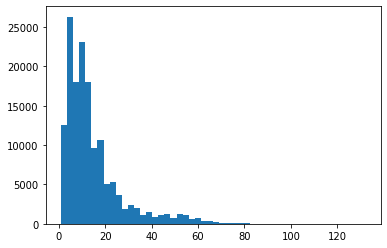

In [82]:
# train_text의 길이 분포를 출력해보세요.
plt.hist([len(s) for s in train_text], bins=50)
plt.show()

### 문제 20. train_cut_text의 길이 분포를 출력해보세요.

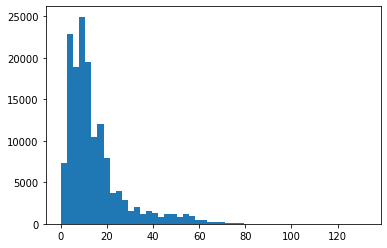

In [87]:
# train_cut_text의 길이 분포를 출력해보세요.
plt.hist([len(s) for s in train_cut_text], bins=50)
plt.show()

### 문제 21. train_cut_bow_text2의 길이 분포를 출력해보세요.

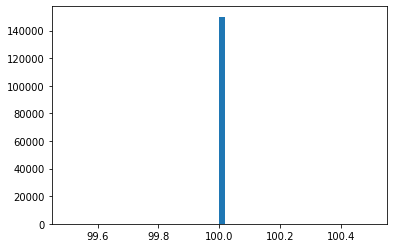

In [84]:
# train_cut_bow_text2의 길이 분포를 출력해보세요.
plt.hist([len(s) for s in train_cut_bow_text2], bins=50)
plt.show()

### 문제 22. label 분포를 출력해보세요.

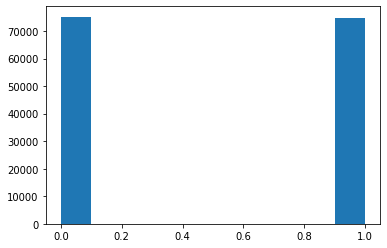

In [86]:
# label 분포를 출력해보세요.
plt.hist(train_sentiment)
plt.show()

### 문제 23. seabon을 이용하여 label 분포를 출력해보세요.

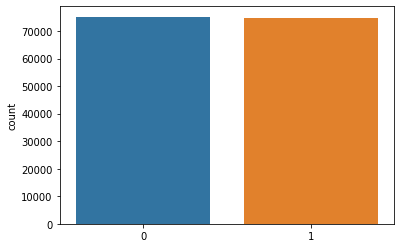

In [88]:
# label 분포를 출력해보세요.
sns.countplot(train_sentiment)

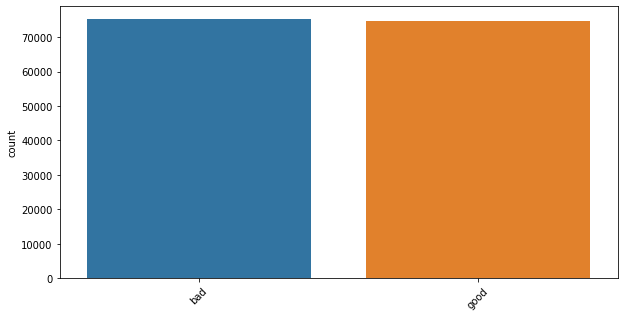

In [89]:
sns.countplot(list(map(lambda x: sentiment2label(x), train_sentiment)))
plt.xticks(rotation=45)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

### 문제 24. sp를 이용해서 text를 decode해보세요.

In [90]:
# sp를 이용해서 text를 decode해보세요.
def bow2text(bow):
    return sp.decode_ids(bow)

In [91]:
bow2text(test_text[0])

'아 더빙.. 진짜 짜증나네요 목소리'

In [92]:
bow2text(test_text[199])

'청춘 영화만이 줄 수 있는 감성이 넘쳐난다. 이 순간 지나가면 다시 돌아오지 않을테지만, 그 순간만큼은 무한할 젊음이 줄 수 있는 그런 감성.'

### 문제 25. train/test 데이터에서 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.

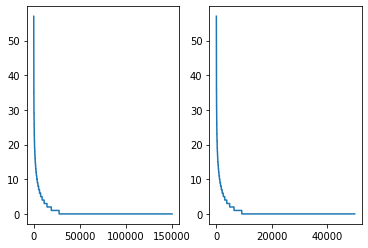

<Figure size 720x1440 with 0 Axes>

In [98]:
# 문서당 가장 많은 횟수로 출현한 word 분포를 출력하세요.
plt.subplot(1,2,1)
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in train_text], reverse=True))
plt.subplot(1,2,2)
plt.plot(sorted([np.unique(doc, return_counts=True)[1].argmax() for doc in test_text], reverse=True))
plt.figure(figsize=(10, 20))
plt.show()

### 문제 26. train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력하세요.

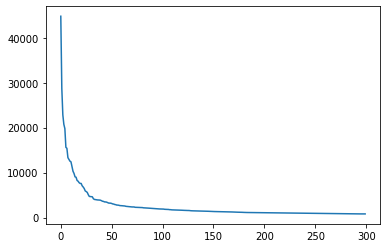

In [113]:
# train/test 전체 문서 당 출현이 가장 높은 word 분포를 출력
table = np.zeros(len(all_words)+5)
for doc in train_text:
    table[np.unique(doc)] += 1
plt.plot(sorted(table, reverse=True)[:300])

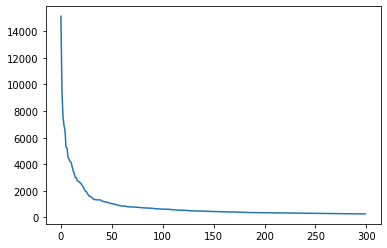

In [114]:
table = np.zeros(len(all_words)+5)
for doc in test_text:
    table[np.unique(doc)] += 1
plt.plot(sorted(table, reverse=True)[:300])

## Step 4. Seq2Seq의 Encoder 이용 모델링

### 문제 27. Encoder이용 classification 모델 구축

In [115]:
# seq2seq 모델을 구축하고 학습모델, encoder를 획득하세요
from keras.layers import Input, Embedding, GRU, Dense
from keras.models import Model

def Seq2Seq():
    inputs_x_bow = Input(shape=(100,))
    embedding = Embedding(20000, 120)
    x = embedding(inputs_x_bow)
    z = GRU(64)(x)
    y = Dense(2, activation='softmax')(z)

    model = Model(inputs_x_bow, y)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 문제 28. 학습 모델을 생성하고 summary를 출력하세요. 

In [116]:
# 학습 모델을 생성하고 summary를 출력하세요.
model = Seq2Seq()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 120)          2400000   
                                                                 
 gru (GRU)                   (None, 64)                35712     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 2,435,842
Trainable params: 2,435,842
Non-trainable params: 0
_________________________________________________________________


### 문제 29. 모델을 학습해보세요.

In [117]:
# 학습모델을 학습해보세요.
hist = model.fit(train_cut_bow_text2, train_onehot_sentiment,
                 validation_data=(test_cut_bow_text2, test_onehot_sentiment),
                 verbose=1, epochs=2)

Epoch 1/2
4688/4688 [==============================] - 149s 30ms/step - loss: 0.3573 - accuracy: 0.8404 - val_loss: 1.5116 - val_accuracy: 0.4999
Epoch 2/2
4688/4688 [==============================] - 139s 30ms/step - loss: 0.2475 - accuracy: 0.8969 - val_loss: 1.6921 - val_accuracy: 0.5004


### 문제 30. 학습 진행 사항을 plt으로 출력하세요.

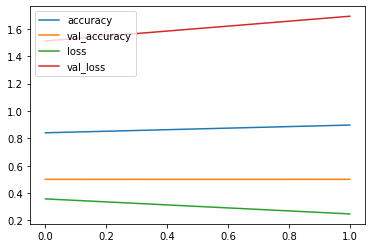

In [118]:
# hist의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

### 문제 31. train_cut_bow_text를 위한 학습 모델을 생성하고 summary를 출력하세요. 

In [119]:
# 학습 모델을 생성하고 summary를 출력하세요.
model2 = Seq2Seq()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 120)          2400000   
                                                                 
 gru_1 (GRU)                 (None, 64)                35712     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,435,842
Trainable params: 2,435,842
Non-trainable params: 0
_________________________________________________________________


### 문제 32. 학습모델을 학습해보세요. 단, train_cut_bow_text를 100으로 길이를 수정하고 실행하세요.

In [120]:
# 학습모델을 학습해보세요.
hist2 = model2.fit(train_cut_bow_text[...,:100], train_onehot_sentiment,
           validation_data=(test_cut_bow_text[...,:100], test_onehot_sentiment),
           verbose=1, epochs=2
           )

Epoch 1/2
4688/4688 [==============================] - 141s 29ms/step - loss: 0.6934 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5035
Epoch 2/2
4688/4688 [==============================] - 145s 31ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.4965


### 문제 33. 학습 진행 사항을 plt으로 출력하세요.

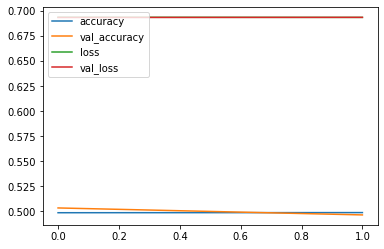

In [121]:
# hist2의 accuracy와 loss를 plt의 plot을 이용하여 출력하는 코드를 작성하세요
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 5. 모델 결과 확인

### 문제 34. 완성된 모델1, 2에서 test 하나를 예측하고 결과를 res1, res2 변수에 저정하세요.

In [122]:
# 완성된 모델에서 test 하나를 예측하고 결과를 res 변수에 저정하세요.
res1 = model.predict(test_cut_bow_text2[15:16])
res1

array([[0.04581768, 0.9541823 ]], dtype=float32)

In [123]:
bow2text(test_text[15])

'ᄀ냥 매번 긴장되고 재밋음ᅲᅲ'

In [124]:
test_onehot_sentiment[15:16]

array([[0., 1.]], dtype=float32)

In [125]:
res2 = model2.predict(test_cut_bow_text[15:16, :100])
res2

array([[0.5046303 , 0.49536964]], dtype=float32)

### 문제 35. res1, res2의 결과를 확인하세요.

In [ ]:
# res1, res2의 결과를 확인하세요.
plt.bar(np.array([0,1]), res1[0], color="red")
plt.bar(np.array([0,1])+0.2, test_onehot_sentiment[0], color="blue")
sentiment2label(res1[0].argmax())

### 문제 36. 평문을 bow로 변환해보세요. 

In [ ]:
# 평문을 bow로 변환해보세요. (oov는 무시합니다.)
text = bow2text(test_text[2])
text, test_sentiment[2]

In [ ]:
def text2bow(text, maxlen = 150):
    seq = sp.encode_as_ids(text)
    bow = tf.keras.preprocessing.sequence.pad_sequences([seq], value=0, padding="post" maxlen=maxlen)
    return bow

In [ ]:
text2bow('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')

In [ ]:
test_text[2]

In [ ]:
text2bow('이영화는 신이내린 감동의 영화입니다')

### 문제 37. text2bow를 이용하여 model1을 통해 결과를 확인하세요.

In [ ]:
# text2bow를 이용하여 model1을 통해 결과를 확인
model.predict(   text2bow('이영화는 신이 내린 최고의 영화입니다')[...,:100]    )

In [ ]:
model.predict(   text2bow('이영화는 선배가 졸업하기전에 대충 만든 수준의 영화입니다')[...,:100]    )

### 문제 38. cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요

In [ ]:
# cut_by_count를 이용하여 20회 이상 등장한 word만 사용하는 bow를 만들어보세요
bow1_cut = tf.keras.preprocessing.sequence.pad_sequences(cut_by_count(text2bow('이영화 보다가 심장이 멈추는줄'), 20), padding="post", maxlen=100)
bow1_cut

In [ ]:
res1 = model.predict(   bow1_cut    )
plt.bar([0,1], res1[0])

### 문제 39. text2bow를 이용하여 model2을 통해 결과를 확인하세요.


In [ ]:
# text2bow를 이용하여 model1을 통해 결과를 확인
model2.predict(   text2bow('이영화는 신이 내린 최고의 영화입니다')[...,:100]    )

### 문제 40. confusion 매트릭스 생성

In [ ]:
# confusion 메트릭스 출력
from sklearn.metrics import confusion_matrix
conf_mat1 = confusion_matrix(test_onehot_sentiment.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1))
print(conf_mat1)

In [ ]:
conf_mat2 = confusion_matrix(test_onehot_sentiment.argmax(axis=1), model2.predict(test_cut_bow_text[...,-100:]).argmax(axis=1))
print(conf_mat2)

### 문제 41. confusion 매트릭스 시각화

In [ ]:
# confusion 매트릭스 시각화
sns.heatmap(conf_mat1)

In [ ]:
sns.heatmap(conf_mat1 / conf_mat1.sum(axis=1))

In [ ]:
sns.heatmap(conf_mat2)

In [ ]:
sns.heatmap(conf_mat2 / conf_mat2.sum(axis=1))

### 문제 42. classification 결과 리포팅

In [ ]:
# classification 결과 리포팅
from sklearn.metrics import classification_report
print(classification_report(test_onehot_sentiment.argmax(axis=1), model.predict(test_cut_bow_text2).argmax(axis=1)))
print(classification_report(test_onehot_sentiment.argmax(axis=1), model2.predict(test_cut_bow_text[...,:100]).argmax(axis=1)))

## Step 6. 모델 저장 및 로드, 다운

### 문제 43. 모델을 저장하세요.

In [ ]:
# 모델을 저장하는 코드를 작성하세요. 
model.save('./lecture011.h5')

### 문제 44. 모델 파일을 새로운 모델에 로드하세요.

In [ ]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./lecture011.h5')
new_model.summary()

### 문제 45. 로드한 모델을 test 데이터로 평가해보세요.


In [ ]:
# 로드한 모델을 test 데이터로 평가해보세요.
loss, acc = new_model.evaluate(test_cut_bow_text2, test_onehot_sentiment, verbose=1)
print(loss, acc)

### 문제 46. 모델을 내 컴퓨터에 저장해보세요

In [ ]:
# 모델을 내 컴퓨터에 저장해보세요.
from google.colab import files
files.download('./lecture011.h5')